# Introduction #

In this exercise you'll train a neural network on the *Fuel Economy* dataset and then explore the effect of the learning rate and batch size on SGD.

When you're ready, run this next cell to set everything up!

In [2]:
# Setup plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In the *Fuel Economy* dataset your task is to predict the fuel economy of an automobile given features like its type of engine or the year it was made. 

First load the dataset by running the cell below.

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

fuel = pd.read_csv('../data/fuel.csv')

X = fuel.copy()
# Remove target
y = X.pop('FE')

preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(X)
y = np.log(y) # log transform target instead of standardizing

input_shape = [X.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [50]


In [9]:
from IPython.display import display

display(fuel.head(3))
display(fuel.shape)
display(X.shape)

,EngDispl,NumCyl,Transmission,FE,AirAspirationMethod,NumGears,TransLockup,TransCreeperGear,DriveDesc,IntakeValvePerCyl,ExhaustValvesPerCyl,CarlineClassDesc,VarValveTiming,VarValveLift
0,4.7,8,AM6,28.0198,NaturallyAspirated,6,1,0,TwoWheelDriveRear,2,2,2Seaters,1,0
1,4.7,8,M6,25.6094,NaturallyAspirated,6,1,0,TwoWheelDriveRear,2,2,2Seaters,1,0
2,4.2,8,M6,26.8000,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,2Seaters,1,0


(1107, 14)

(1107, 50)

In [22]:
for feature in fuel.select_dtypes(exclude=['int', 'float']):
    print('*'*20)
    display(fuel[feature].value_counts(ascending=False))
    print('*'*20)


********************


S6       213
M6       167
A4       143
A6       126
A5       114
M5       101
A7        59
AV        55
S5        48
S7        22
S4        13
AVS6      13
AM6       11
S8        11
Other      6
AM7        5
Name: Transmission, dtype: int64

********************
********************


NaturallyAspirated    921
Turbocharged          168
Supercharged           18
Name: AirAspirationMethod, dtype: int64

********************
********************


TwoWheelDriveFront        382
TwoWheelDriveRear         350
AllWheelDrive             205
FourWheelDrive            159
ParttimeFourWheelDrive     11
Name: DriveDesc, dtype: int64

********************
********************


SpecialPurposeVehicleSUV4WD        170
CompactCars                        145
MidsizeCars                        135
SpecialPurposeVehicleSUV2WD        133
SubcompactCars                     116
LargeCars                           75
SmallStationWagons                  68
2Seaters                            67
MinicompactCars                     49
SmallPickupTrucks2WD                33
StandardPickupTrucks4WD             29
StandardPickupTrucks2WD             27
SmallPickupTrucks4WD                22
SpecialPurposeVehicleminivan2WD     15
VansCargoTypes                      10
Other                                9
VansPassengerType                    4
Name: CarlineClassDesc, dtype: int64

********************


Take a look at the data if you like. Our target in this case is the `'FE'` column and the remaining columns are the features.

In [28]:
# Uncomment to see original data
display(fuel.head(), fuel.shape)
# Uncomment to see processed features
pd.DataFrame(X[:,:]).size

,EngDispl,NumCyl,Transmission,FE,AirAspirationMethod,NumGears,TransLockup,TransCreeperGear,DriveDesc,IntakeValvePerCyl,ExhaustValvesPerCyl,CarlineClassDesc,VarValveTiming,VarValveLift
0,4.7,8,AM6,28.0198,NaturallyAspirated,6,1,0,TwoWheelDriveRear,2,2,2Seaters,1,0
1,4.7,8,M6,25.6094,NaturallyAspirated,6,1,0,TwoWheelDriveRear,2,2,2Seaters,1,0
2,4.2,8,M6,26.8000,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,2Seaters,1,0
3,4.2,8,AM6,25.0451,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,2Seaters,1,0
4,5.2,10,AM6,24.8000,NaturallyAspirated,6,0,0,AllWheelDrive,2,2,2Seaters,1,0


(1107, 14)

55350

Run the next cell to define the network we'll use for this task.

In [26]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),    
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

2022-01-05 17:44:05.437085: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-05 17:44:05.438259: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-05 17:44:05.445384: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 31,361
Trainable params: 31,361
Non-trainable params: 0
_________________________________________________________________


# 1) Add Loss and Optimizer

Before training the network we need to define the loss and optimizer we'll use. Using the model's `compile` method, add the Adam optimizer and MAE loss.

In [29]:
# YOUR CODE HERE
model.compile(optimizer='adam',
             loss='mae',
             metrics=['mae'])


# 2) Train Model

Once you've defined the model and compiled it with a loss and optimizer you're ready for training. Train the network for 200 epochs with a batch size of 128. The input data is `X` with target `y`.

In [34]:
stopping = EarlyStopping(monitor='loss',
                         patience=20)

In [35]:
# YOUR CODE HERE
history = model.fit(X, y,
                    batch_size=128,
                   epochs=200,
                   callbacks=[stopping])

Epoch 1/200
9/9 [==============================] - 0s 37ms/step - loss: 0.0460 - mae: 0.0460
Epoch 2/200
9/9 [==============================] - 0s 12ms/step - loss: 0.0424 - mae: 0.0424
Epoch 3/200
9/9 [==============================] - 0s 19ms/step - loss: 0.0385 - mae: 0.0385
Epoch 4/200
9/9 [==============================] - 0s 14ms/step - loss: 0.0396 - mae: 0.0396
Epoch 5/200
9/9 [==============================] - 0s 19ms/step - loss: 0.0370 - mae: 0.0370
Epoch 6/200
9/9 [==============================] - 0s 13ms/step - loss: 0.0346 - mae: 0.0346
Epoch 7/200
9/9 [==============================] - 0s 27ms/step - loss: 0.0423 - mae: 0.0423
Epoch 8/200
9/9 [==============================] - 0s 26ms/step - loss: 0.0519 - mae: 0.0519
Epoch 9/200
9/9 [==============================] - 0s 20ms/step - loss: 0.0532 - mae: 0.0532
Epoch 10/200
9/9 [==============================] - 0s 37ms/step - loss: 0.0591 - mae: 0.0591
Epoch 11/200
9/9 [==============================] - 0s 48ms/step - lo

The last step is to look at the loss curves and evaluate the training. Run the cell below to get a plot of the training loss.

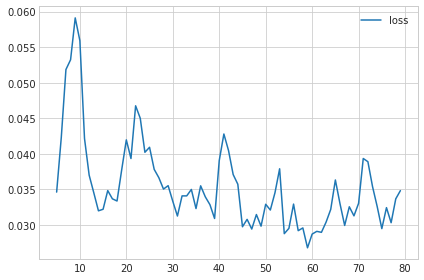

In [36]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[5:, ['loss']].plot();

# 3) Evaluate Training

If you trained the model longer, would you expect the loss to decrease further?

This depends on how the loss has evolved during training: if the learning curves have levelled off, there won't usually be any advantage to training for additional epochs. Conversely, if the loss appears to still be decreasing, then training for longer could be advantageous.

With the learning rate and the batch size, you have some control over:
- How long it takes to train a model
- How noisy the learning curves are
- How small the loss becomes

To get a better understanding of these two parameters, we'll look at the linear model, our ppsimplest neural network. Having only a single weight and a bias, it's easier to see what effect a change of parameter has.

The next cell will generate an animation like the one in the tutorial. Change the values for `learning_rate`, `batch_size`, and `num_examples` (how many data points) and then run the cell. (It may take a moment or two.) Try the following combinations, or try some of your own:

| `learning_rate` | `batch_size` | `num_examples` |
|-----------------|--------------|----------------|
| 0.05            | 32           | 256            |
| 0.05            | 2            | 256            |
| 0.05            | 128          | 256            |
| 0.02            | 32           | 256            |
| 0.2             | 32           | 256            |
| 1.0             | 32           | 256            |
| 0.9             | 4096         | 8192           |
| 0.99            | 4096         | 8192           |

In [40]:
"""
# YOUR CODE HERE: Experiment with different values for the learning rate, batch size, and number of examples
learning_rate = 0.1
batch_size = 4096
num_examples = 8192

animate_sgd(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_examples=num_examples,
    # You can also change these, if you like
    steps=50, # total training steps (batches seen)
    true_w=3.0, # the slope of the data
    true_b=2.0, # the bias of the data
)
"""

'\n# YOUR CODE HERE: Experiment with different values for the learning rate, batch size, and number of examples\nlearning_rate = 0.1\nbatch_size = 4096\nnum_examples = 8192\n\nanimate_sgd(\n    learning_rate=learning_rate,\n    batch_size=batch_size,\n    num_examples=num_examples,\n    # You can also change these, if you like\n    steps=50, # total training steps (batches seen)\n    true_w=3.0, # the slope of the data\n    true_b=2.0, # the bias of the data\n)\n'

# 4) Learning Rate and Batch Size

What effect did changing these parameters have? After you've thought about it, run the cell below for some discussion.

<p style='color: green'>Correct:</p>

You probably saw that smaller batch sizes gave noisier weight updates and loss curves. This is because each batch is a small sample of data and smaller samples tend to give noisier estimates. Smaller batches can have an "averaging" effect though which can be beneficial.

Smaller learning rates make the updates smaller and the training takes longer to converge. Large learning rates can speed up training, but don't "settle in" to a minimum as well. When the learning rate is too large, the training can fail completely. (Try setting the learning rate to a large value like 0.99 to see this.)